In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [81]:
export = pd.read_csv('data\waak\\test\export.csv')

In [82]:
export = export[export['X'] >= 0]
export = export[export['Y'] >= 0]
export = export[export['X'] <= 4225]
export = export[export['Y'] <= 1560]

interval_min = 0
interval_max = 1920
export['X'] = (export['X'] - np.min(export['X'])) / (np.max(export['X']) - np.min(export['X'])) * (interval_max - interval_min) + interval_min

interval_min = 0
interval_max = 1060
export['Y'] = (export['Y'] - np.min(export['Y'])) / (np.max(export['Y']) - np.min(export['Y'])) * (interval_max - interval_min) + interval_min


x1, y1, w, h = 965.0, 374.0, 1277.0, 632.0
aois = [(965.0, 374.0, 1277.0, 632.0), (597.0, 582.0, 877.0, 827.0), (1396.0, 524.0, 1677.0, 796.0)]

In [83]:
def Calc(x1, y1, w, h):


    data = pd.DataFrame()

    x2, y2 = x1+w, y1+h

    in_aoi = (x1 <= export['X']) & (export['X'] <= x2) & (y1 <= export['Y']) & (export['Y'] <= y2)

    export['IN'] = in_aoi

    visits = []
    tmp_visits = []
    collecting = False


    for index, row in export.iterrows():
        
        if row['IN'] == True and row['Eye movement type'] == 'Saccade':
            tmp_visits.append(row)
            collecting = True

        elif row['IN'] == True and collecting:
            tmp_visits.append(row)

        else:
            tmp_visits = pd.DataFrame(tmp_visits)
            if len(tmp_visits) > 5:

                if 'Fixation' in tmp_visits['Eye movement type'].unique():
                    visits.append(tmp_visits)

            tmp_visits = []
            collecting = False
    
    
    # calculates total time spent in AoI visit and time spent each visit
    for idx, visit in enumerate(visits):

        start_time = visit['Recording timestamp'].values[0]
        end_time = visit['Recording timestamp'].values[-1]

        duration = end_time - start_time

        data.loc[idx, 'dwell_time'] = duration
        data.loc[idx, 'visit_start'] = start_time
        data.loc[idx, 'visit_end'] = end_time
    
        duration = 0

        for row_idx, row in visit.iterrows():

            if row['Eye movement type'] == 'Fixation':
                duration += row['Gaze event duration']
            
        data.loc[idx, 'total_fixation_time'] = duration / 1000


        # calculates avg pupil sizes for l en r and change in pupil size
        pupil_list_l = []
        pupil_list_r = []
        timestamps_list = []

        pupil_visit = visit.dropna(subset=['Pupil diameter left', 'Pupil diameter right'])
        pupil_l = pupil_visit['Pupil diameter left']
        pupil_r = pupil_visit['Pupil diameter right']
        timestamps = pupil_visit['Recording timestamp']

        if len(pupil_l) != 0 and len(pupil_r) != 0:

            pupil_list_l.append(pupil_l)
            pupil_list_r.append(pupil_r)
            timestamps_list.append(timestamps)

            l_avg = np.average(pupil_l)
            r_avg = np.average(pupil_r)

            l_diff = np.average(np.diff(pupil_l) / np.diff(timestamps))
            r_diff = np.average(np.diff(pupil_r) / np.diff(timestamps))

            avg = np.average(l_avg + r_avg)
            diff = np.average(l_diff + r_diff)

            data.loc[idx, 'pupil_dia_avg'] = avg
            data.loc[idx, 'pupil_dia_diff'] = diff



        # calculates movement types in AoI
        types = []

        unique, counts = np.unique(visit['Eye movement type'], return_counts=True)
        
        for type, count in zip(unique, counts):
            data.loc[idx, type + '_count'] = count

            if type not in types:
                types.append(type + '_count')
    
        for type in types:
            data[type].fillna(0, inplace=True)
        
    return data

In [84]:
aoi_data = []
for aoi in aois:
    aoi_data.append(Calc(*aoi))

c:\Python\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Python\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [85]:
max_length = 0

for data in aoi_data:
    if len(data) > max_length:
        max_length = len(data)
    
plot_width = max_length // 3
plot_height = len(aoi_data) * 10

In [86]:
aoi_data[0].head()

,dwell_time,visit_start,visit_end,total_fixation_time,pupil_dia_avg,pupil_dia_diff,Fixation_count,Saccade_count,Unclassified_count
0,239.860,4897.197,5137.057,0.28,7.483778,0.006584,2.0,8.0,3.0
1,339.802,5256.989,5596.791,0.64,7.771588,0.000194,8.0,8.0,2.0
2,939.458,9094.790,10034.248,3.30,8.351667,0.000138,21.0,14.0,6.0
3,99.945,10973.712,11073.657,1.00,7.417500,0.000891,5.0,1.0,0.0
4,1159.339,11193.584,12352.923,0.98,7.934774,0.000441,7.0,31.0,7.0


In [87]:
# grafieken per aoi




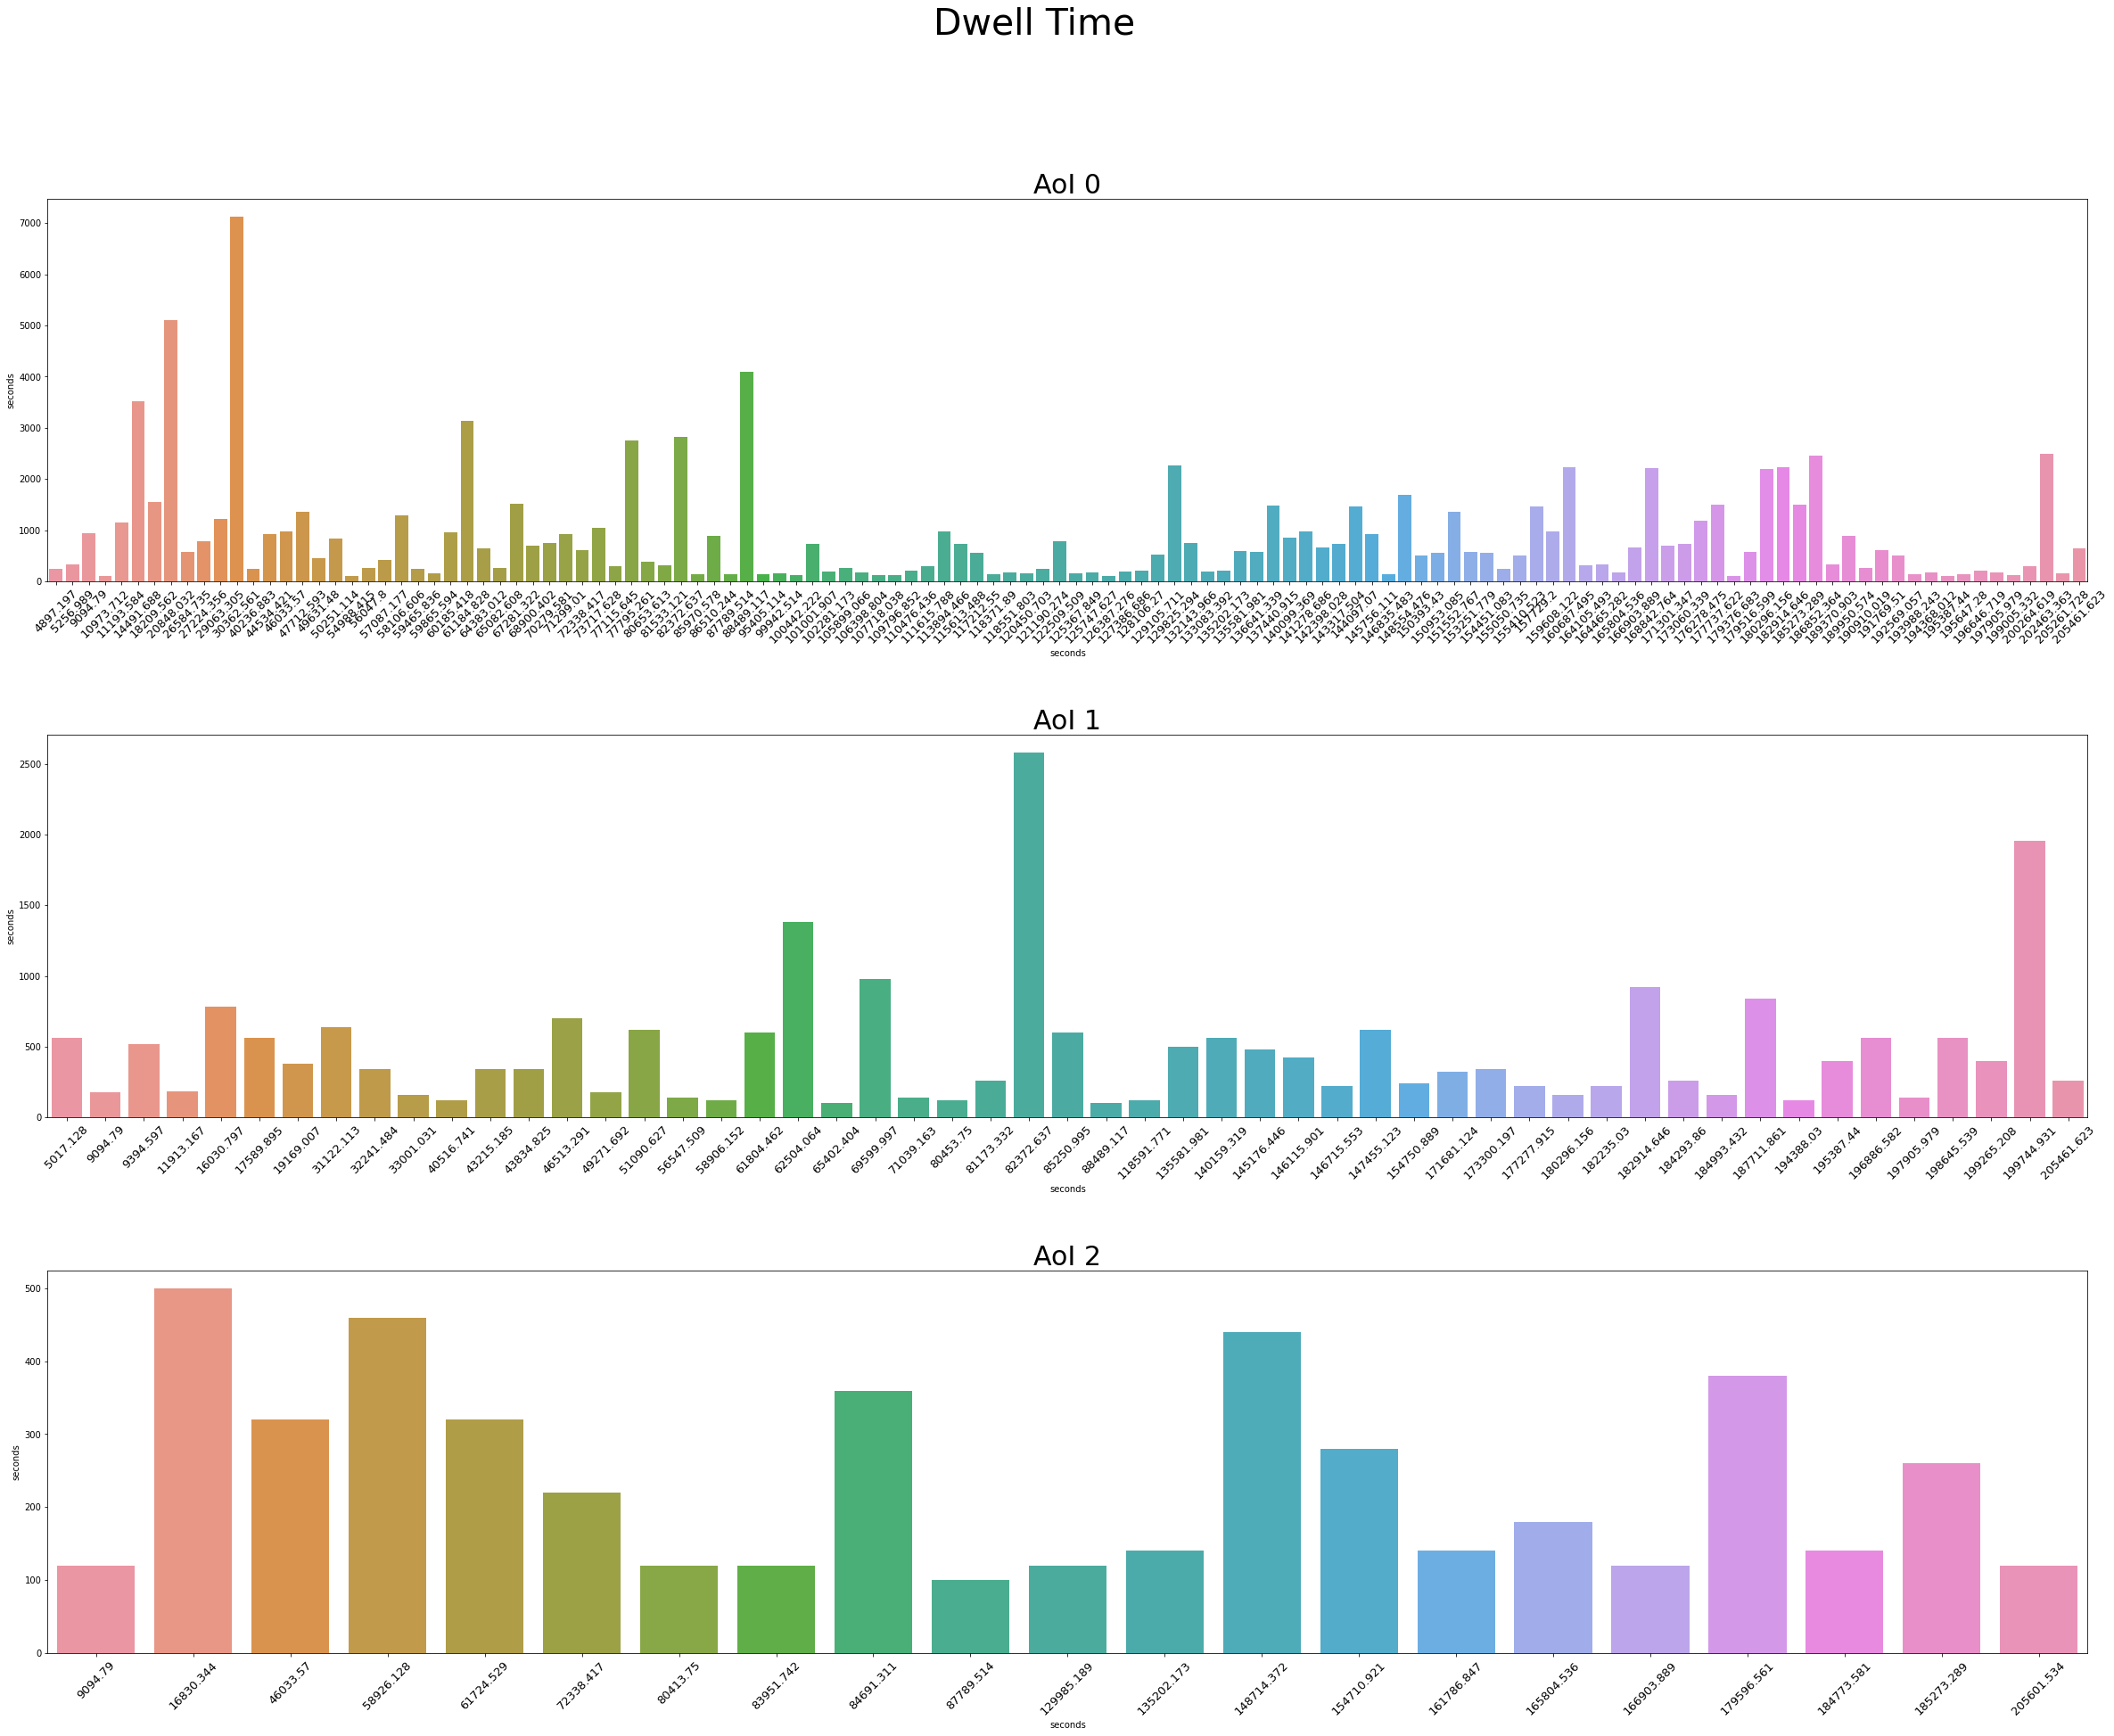

In [88]:
# grafieken per visit per aoi


plt.figure(figsize = (plot_width, plot_height))
plt.suptitle('Dwell Time', fontsize = plot_width)
plt.subplots_adjust(hspace=0.4)

for n, aoi in enumerate(aoi_data):

    # add a new subplot iteratively
    ax = plt.subplot(len(aoi_data), 1, n + 1)
    ax = sns.barplot(data=aoi, y='dwell_time', x=aoi['visit_start'], ci=None)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, size = plot_width // 3)
    ax.set(xlabel='seconds')
    ax.set(ylabel='seconds')
    ax.set_title(f'AoI {n}', fontsize=plot_height)

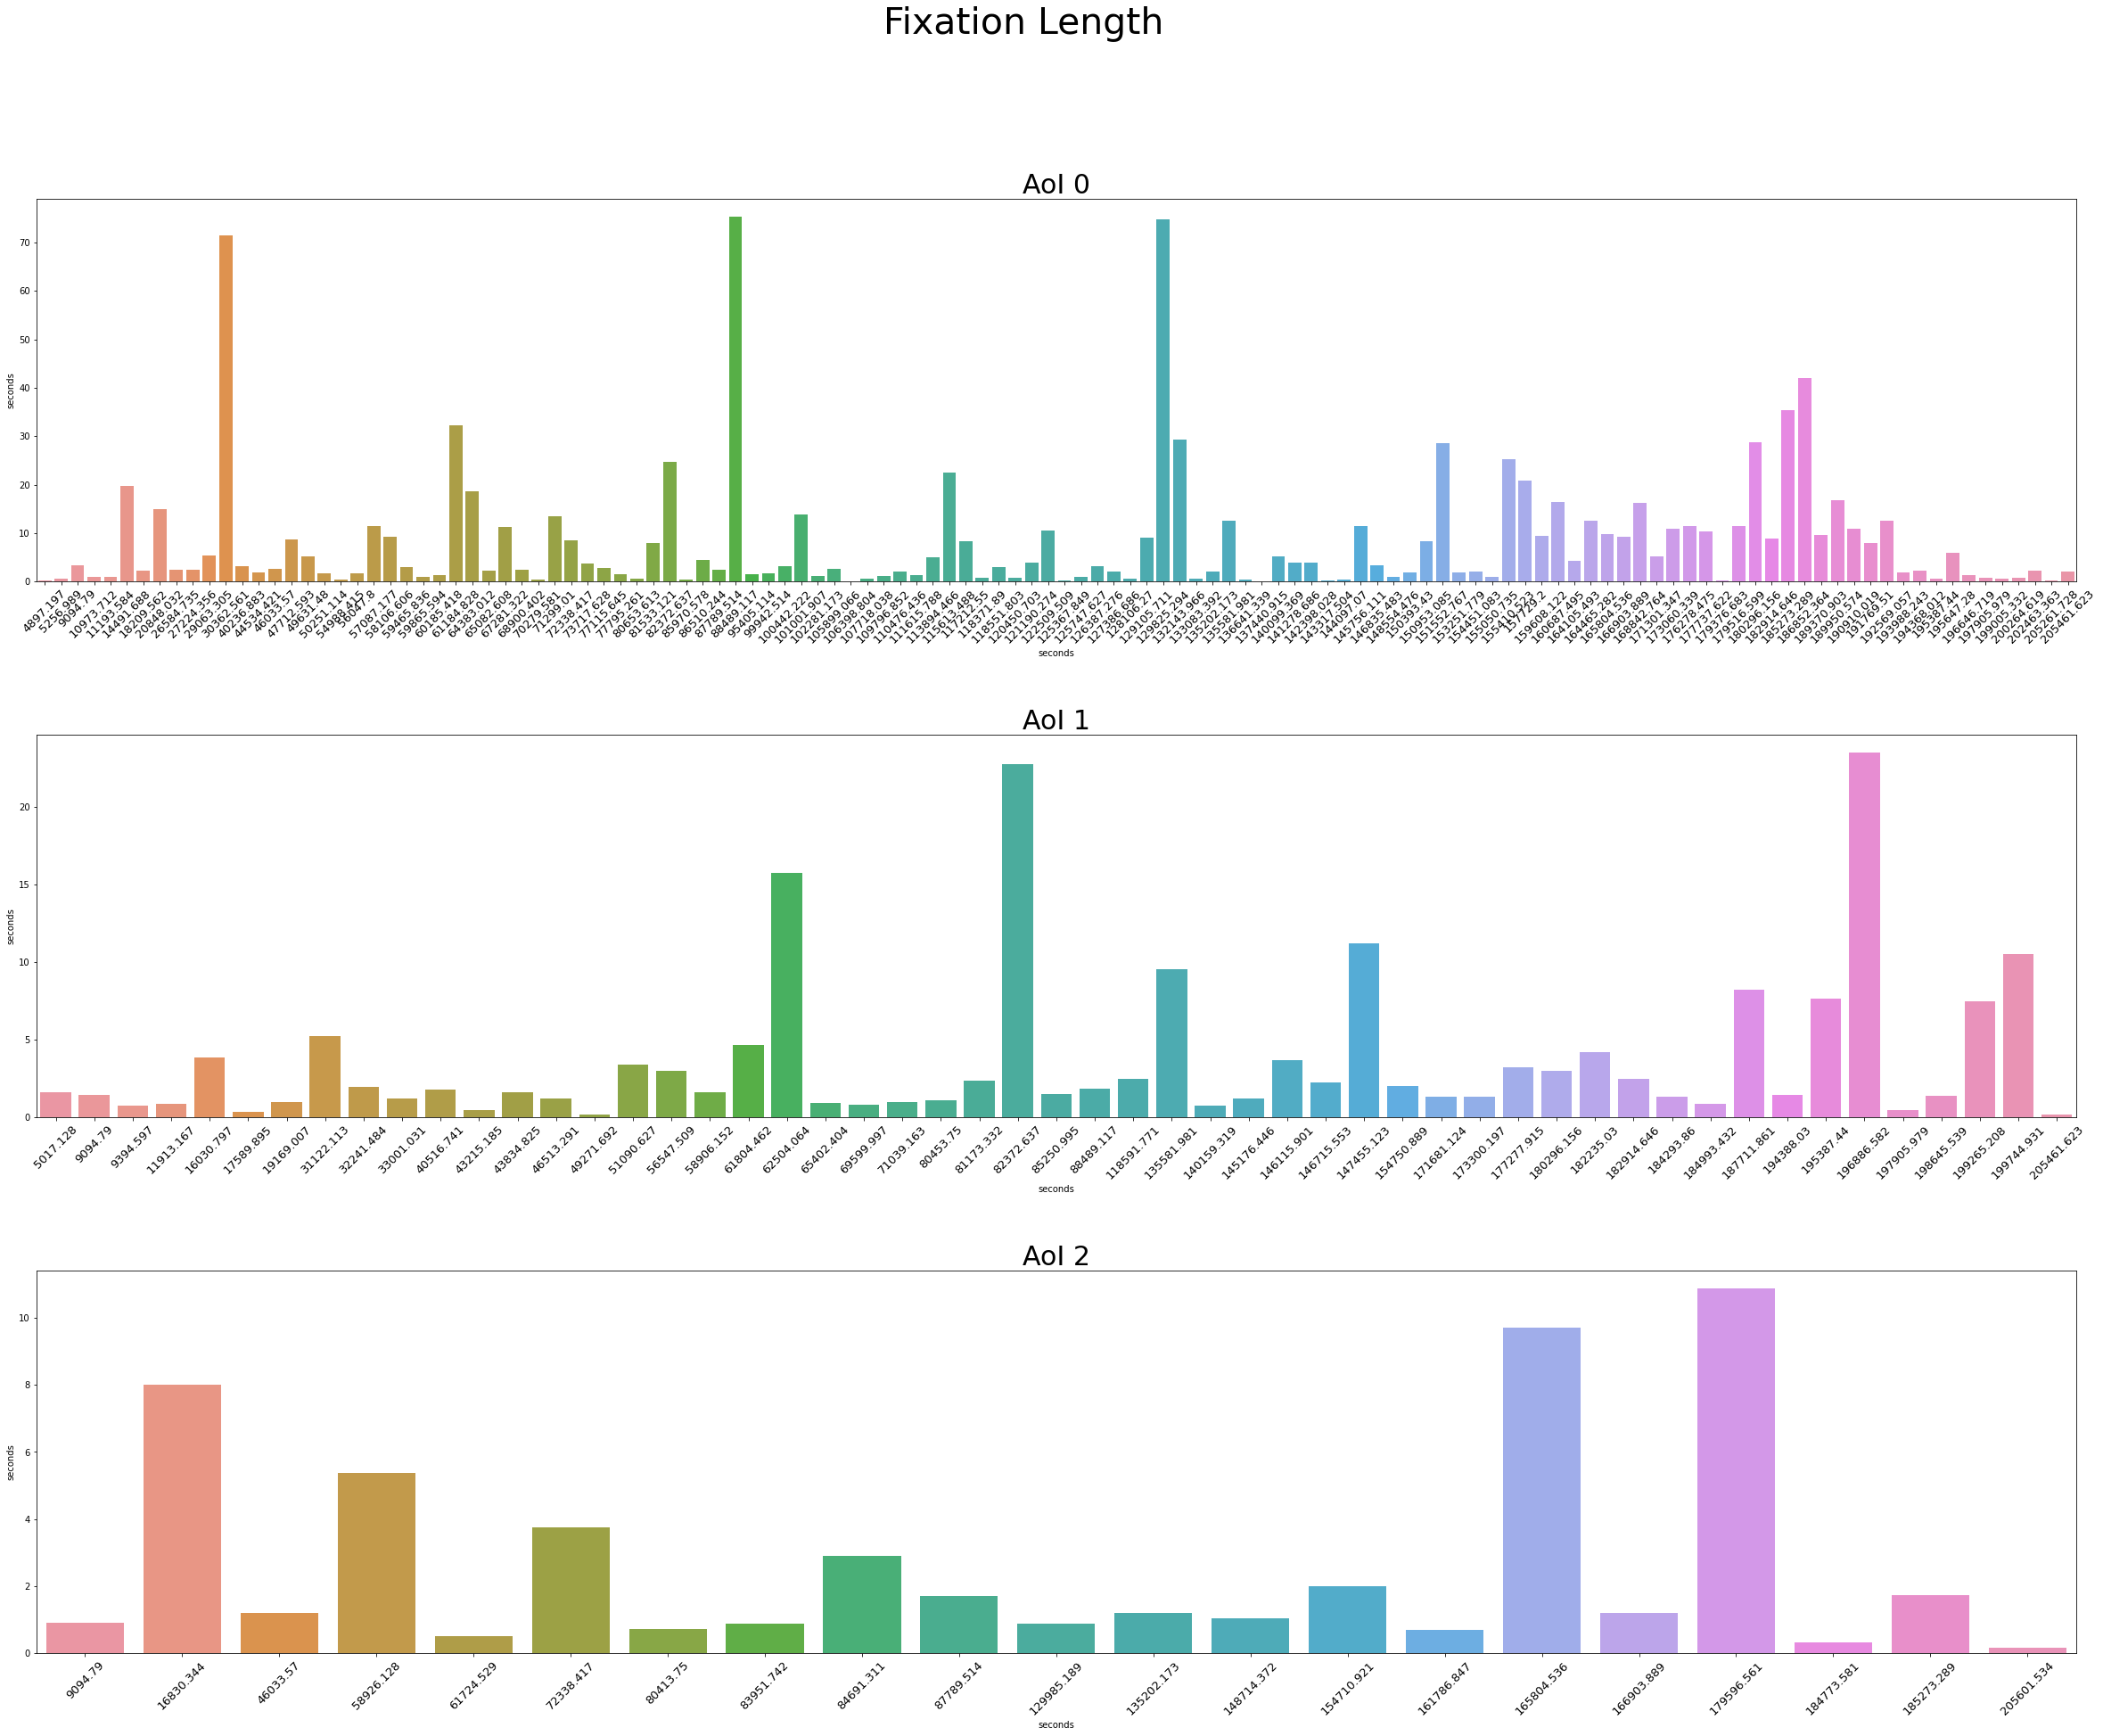

In [89]:
plt.figure(figsize = (plot_width, plot_height))
plt.suptitle('Fixation Length', fontsize = plot_width)
plt.subplots_adjust(hspace=0.4)

for n, aoi in enumerate(aoi_data):

    # add a new subplot iteratively
    ax = plt.subplot(len(aoi_data), 1, n + 1)
    ax = sns.barplot(data=aoi, y='total_fixation_time', x=aoi['visit_start'], ci=None)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, size = plot_width // 3)
    ax.set(xlabel='seconds')
    ax.set(ylabel='seconds')

    ax.set_title(f'AoI {n}', fontsize=plot_height)



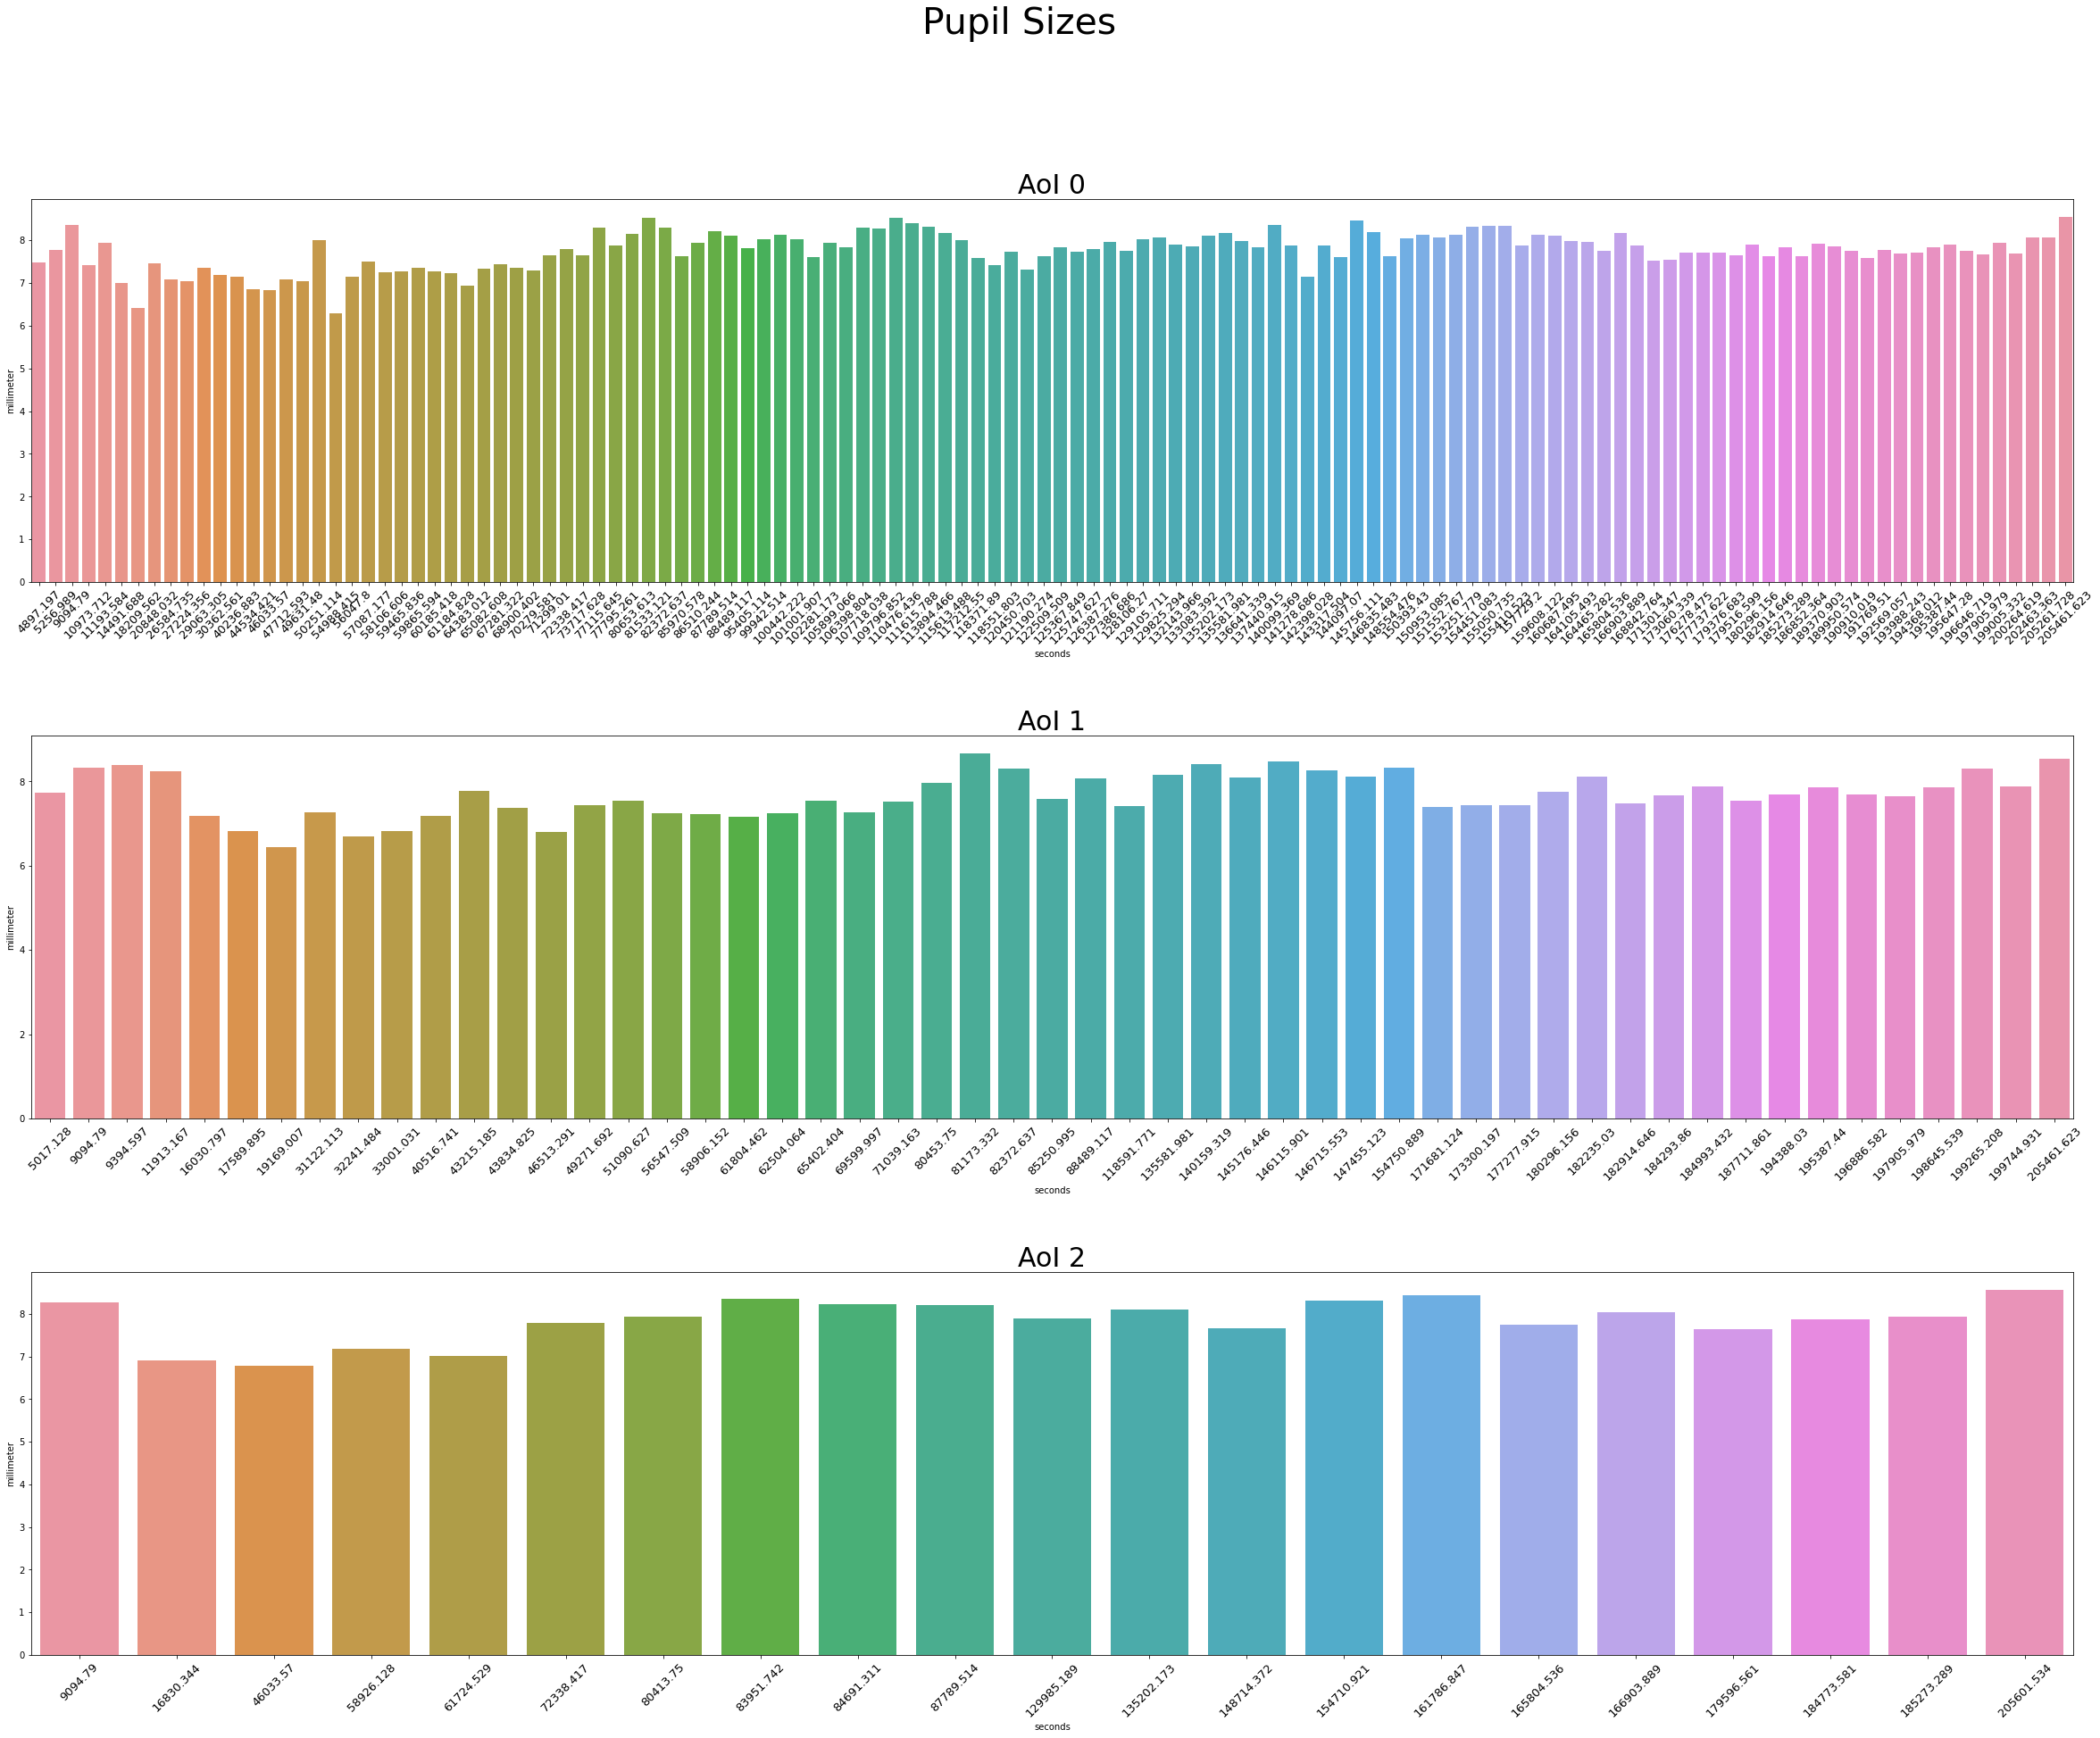

In [90]:
plt.figure(figsize = (plot_width, plot_height))
plt.suptitle('Pupil Sizes', fontsize = plot_width)
plt.subplots_adjust(hspace=0.4)

for n, aoi in enumerate(aoi_data):

    # add a new subplot iteratively
    ax = plt.subplot(len(aoi_data), 1, n + 1)
    ax = sns.barplot(data=aoi, y='pupil_dia_avg', x=aoi['visit_start'], ci=None)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, size = plot_width // 3)
    ax.set(xlabel='seconds')
    ax.set(ylabel='millimeter')
    ax.set_title(f'AoI {n}', fontsize=plot_height)

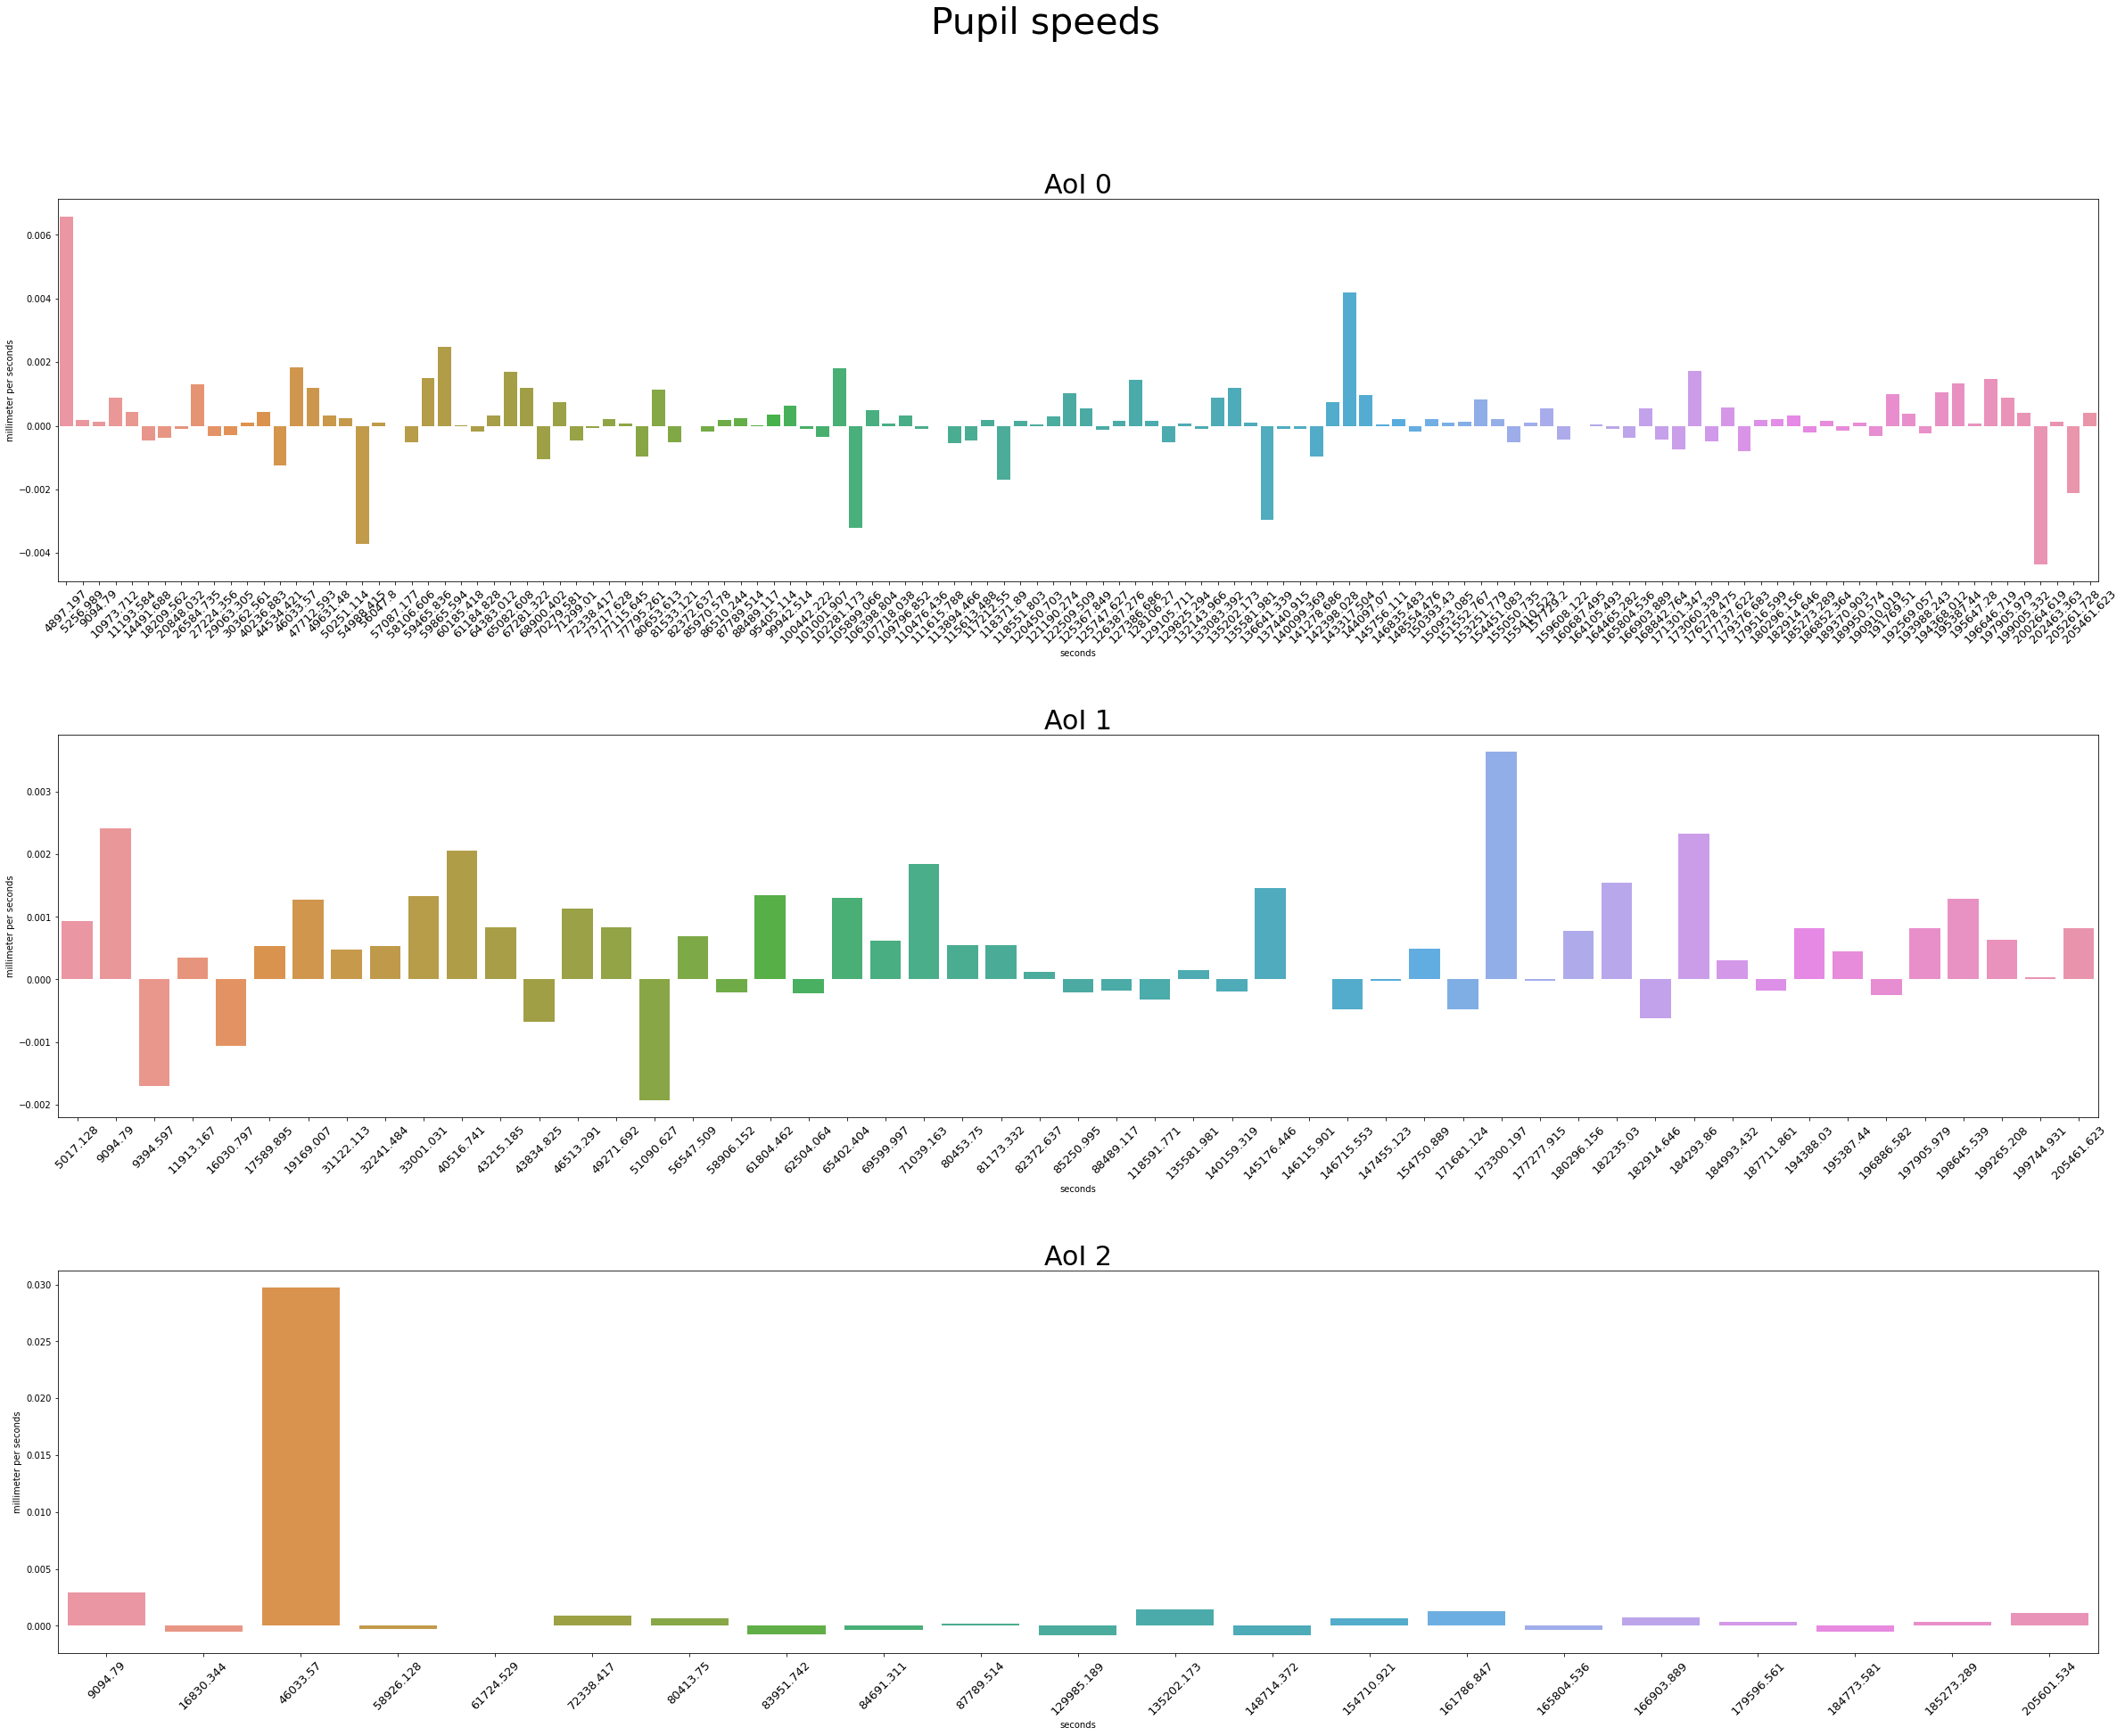

In [91]:
plt.figure(figsize = (plot_width, plot_height))
plt.suptitle('Pupil speeds', fontsize = plot_width)
plt.subplots_adjust(hspace=0.4)

for n, aoi in enumerate(aoi_data):

    # add a new subplot iteratively
    ax = plt.subplot(len(aoi_data), 1, n + 1)
    ax = sns.barplot(data=aoi, y='pupil_dia_diff', x=aoi['visit_start'], ci=None)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, size = plot_width // 3)
    ax.set(xlabel='seconds')
    ax.set(ylabel='millimeter per seconds')
    ax.set_title(f'AoI {n}', fontsize=plot_height)